# DMD on three sinusoids

In this notebook we test applying DMD to a noisy signal that is the sum of three sinusoids with different frequencies and spatial extent.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pydmd import BOPDMD
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_summary
from signal_generator import SignalGenerator

Generate the signal using the SignalGenerator class.

In [2]:
signal_generator = SignalGenerator(x_min=-5, x_max=5, t_max=60)
signal_generator.add_sinusoid1(a=2, omega=0.5, k=1.5)
signal_generator.add_sinusoid2(a=3, omega=2.5, c=1.5, k=0.5)
signal_generator.add_sinusoid2(a=3, omega=5, c=-1.5, k=0.5)
signal_generator.add_noise(random_seed=42)

Plot the sinusoids that compose the signal and the signal itself.

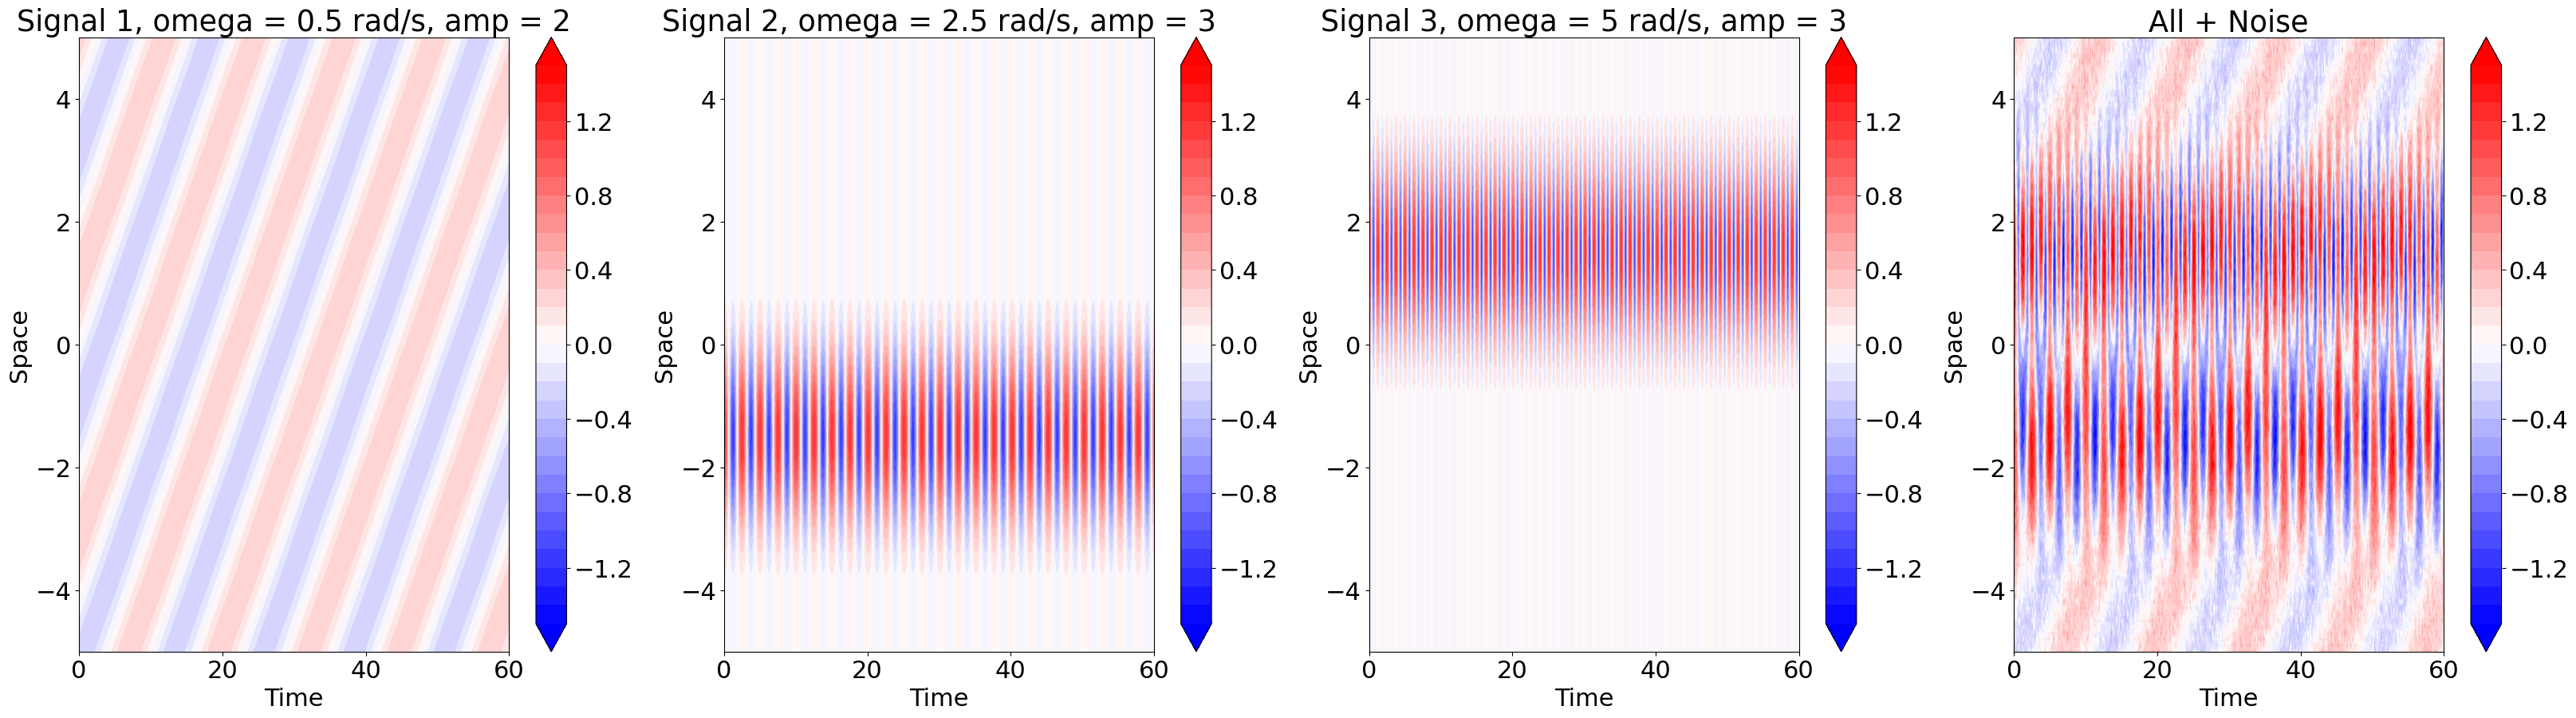

In [3]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 4, 1)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[0]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 1, omega = {signal_generator.components[0]["omega"]} rad/s, amp = {signal_generator.components[0]["a"]}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 2)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[1]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 2, omega = {signal_generator.components[1]["omega"]} rad/s, amp = {signal_generator.components[1]["a"]}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 3)
contour = ax.contourf(
    signal_generator.T, signal_generator.X, signal_generator.components[2]["signal"], levels=levels, cmap='bwr', extend='both'
    )
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 3, omega = {signal_generator.components[2]["omega"]} rad/s, amp = {signal_generator.components[2]["a"]}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 4)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.signal, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('All + Noise')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

## Build the DMD model

Here we will use Algorithm 3 of Askham and Kutz (2018) to build the DMD model (i.e. SVD is applied to the data matrix before applying DMD).

In [4]:
svd_rank = 6  # we have three components, so we need 6 DMD modes
delay = 2  # apply time-delay embedding

In [5]:
optdmd = BOPDMD(
    svd_rank=svd_rank,
    num_trials=0,
    use_proj=True,
    varpro_opts_dict={"verbose": True},
    )
delay_optdmd = hankel_preprocessing(optdmd, d=delay)

Fit the DMD model to 80% of the data and predict the remaining 20%.

In [6]:
# fit DMD model to 80% of the data
train_frac = 0.8
f_train = signal_generator.signal[:int(train_frac * signal_generator.signal.shape[0]), :]
t_train = signal_generator.t[:int(train_frac * signal_generator.signal.shape[0])]
f_test = signal_generator.signal[int(train_frac * signal_generator.signal.shape[0]):, :]
t_test = signal_generator.t[int(train_frac * signal_generator.signal.shape[0]):]

In [7]:
t_delay = t_train[:-delay+1]
delay_optdmd.fit(f_train.T, t=t_delay)

Step 1 Error 0.6423493913273959 Lambda 0.3333333333333333
Step 2 Error 0.6422627429391898 Lambda 0.5024262044834553
Step 3 Error 0.6417661269210422 Lambda 257.2422166955291
Step 4 Error 0.6417290681716686 Lambda 85.74740556517636
Step 5 Error 0.6416593715214693 Lambda 28.582468521725453
Step 6 Error 0.6413616719331487 Lambda 9.527489507241818
Step 7 Error 0.6401730545728375 Lambda 3.1758298357472725
Step 8 Error 0.6352770419490328 Lambda 1.0586099452490907
Step 9 Error 0.6201931313273147 Lambda 0.35286998174969686
Step 10 Error 0.5839694114216831 Lambda 0.11762332724989895
Step 11 Error 0.4992898743395892 Lambda 0.03920777574996631
Step 12 Error 0.2454953347315567 Lambda 0.013069258583322103
Step 13 Error 0.035858404340382566 Lambda 0.004356419527774034
Step 14 Error 0.03178020564381486 Lambda 0.0014521398425913446
Step 15 Error 0.03178017291592939 Lambda 0.00048404661419711485
Step 16 Error 0.03178017291571374 Lambda 0.00016134887139903828
Step 17 Error 0.03178017291571371 Lambda 5.28

/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/toy_dataset/.venv/lib/python3.10/site-packages/pydmd/bopdmd.py:812: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


Plot the results. As can be seen, the DMD model is able to accurately capture the three sinusoids that compose the signal in terms of spatial and temporal dynamics.

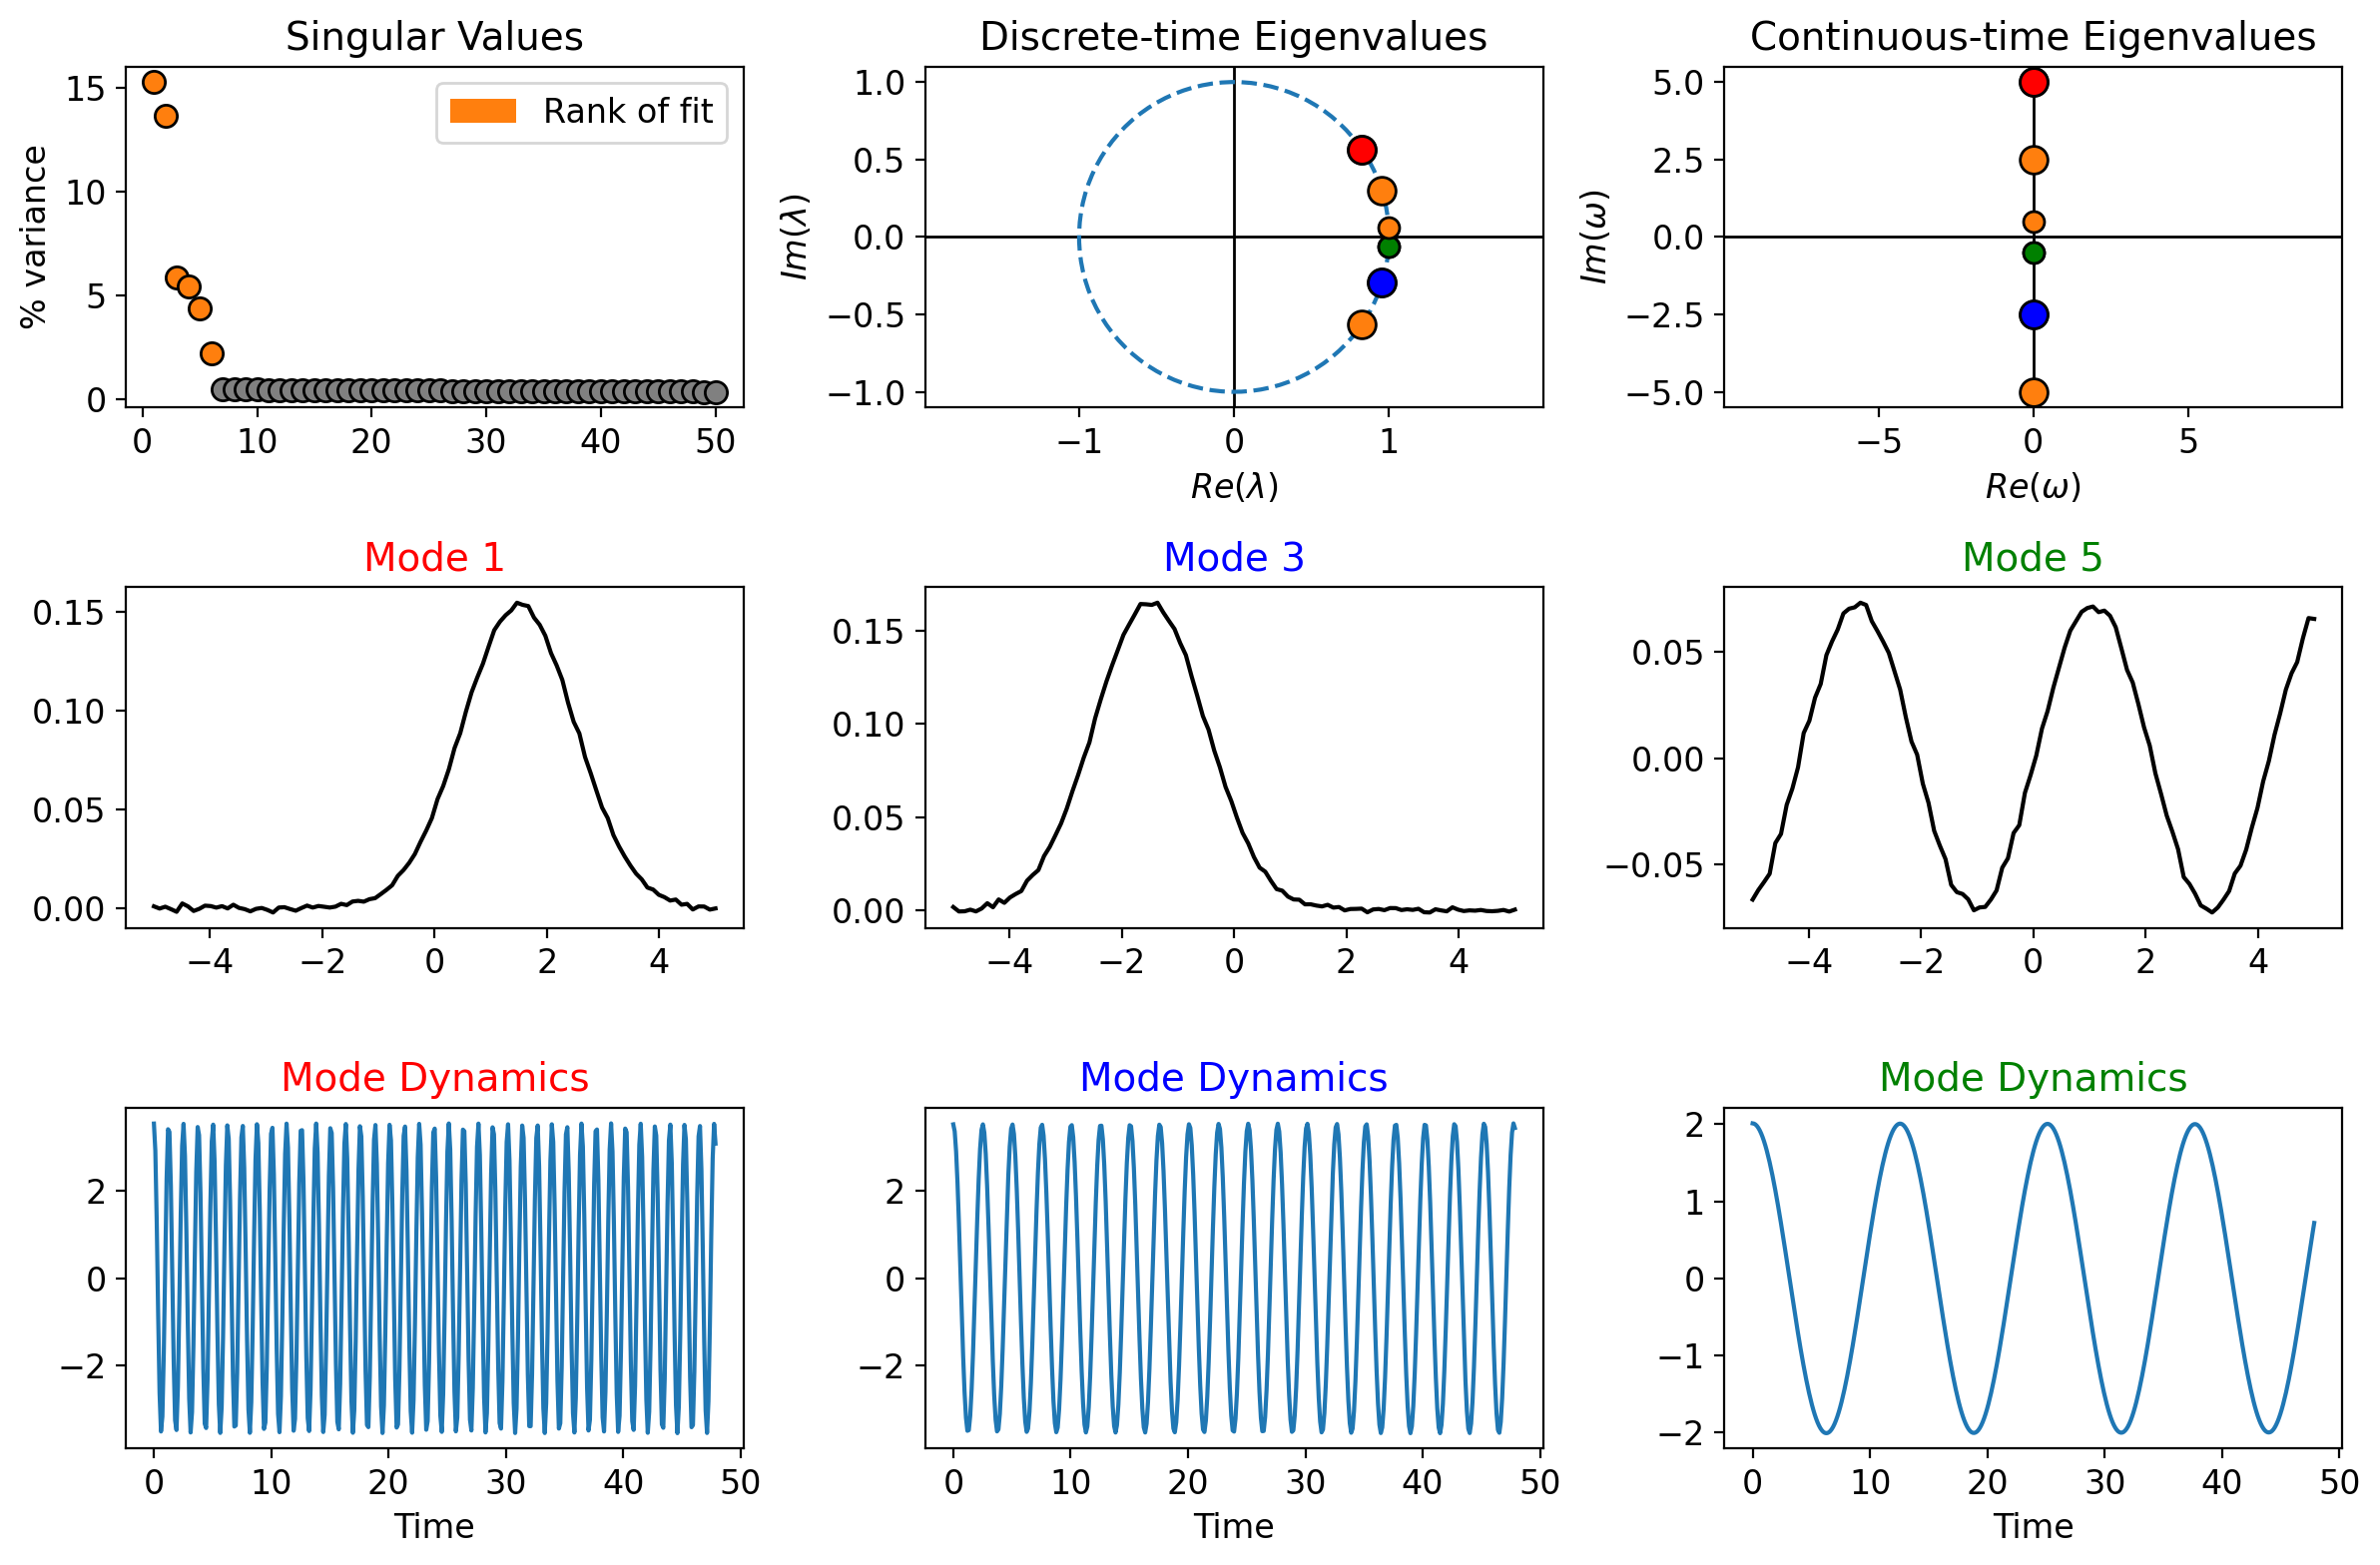

In [8]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

Inspect the mode amplitudes and eigenvalues. As can be seen, the mode frequencies are very close to the true frequencies of the sinusoids, and so are the mode amplitudes (keep in mind that the amplitudes specified by user inputs actually refer to the area under the curve for the Gaussian pulses, which will be somewhat different to the mode amplitudes captured by DMD).

In [9]:
sorted_index = np.argsort(delay_optdmd.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd.amplitudes[sorted_index]}")
print(f"Eigenvalues: {delay_optdmd.eigs[sorted_index]}")

Amplitudes: [3.53997124 3.53997124 3.52198792 3.52198792 2.00929746 2.00929746]
Eigenvalues: [ 3.68306671e-05+4.99999911j  3.68306671e-05-4.99999911j
  1.61747857e-04-2.49981832j  1.61747857e-04+2.49981832j
 -1.22908554e-04-0.5000424j  -1.22908554e-04+0.5000424j ]


Sort the modes based on their amplitude.

In [10]:
eigs = delay_optdmd.eigs[sorted_index]
modes = delay_optdmd.modes[:, sorted_index]
dynamics = delay_optdmd.dynamics[sorted_index, :]
amps = delay_optdmd.amplitudes[sorted_index]

In [11]:
def reconstruct(mode, eig, amp, t=t_train, x_lim=signal_generator.x.shape[0]):
    """Reconstruct the signal using a single DMD mode."""
    reconstruction = np.linalg.multi_dot([mode.reshape(-1, 1), np.diag([amp]), np.exp(np.outer(eig, t))]).real
    reconstruction = reconstruction[:x_lim, :]
    return reconstruction

Plot contours of the reconstructed data from each mode. These should ideally be the same as the individual signals that compose the data (plotted above).

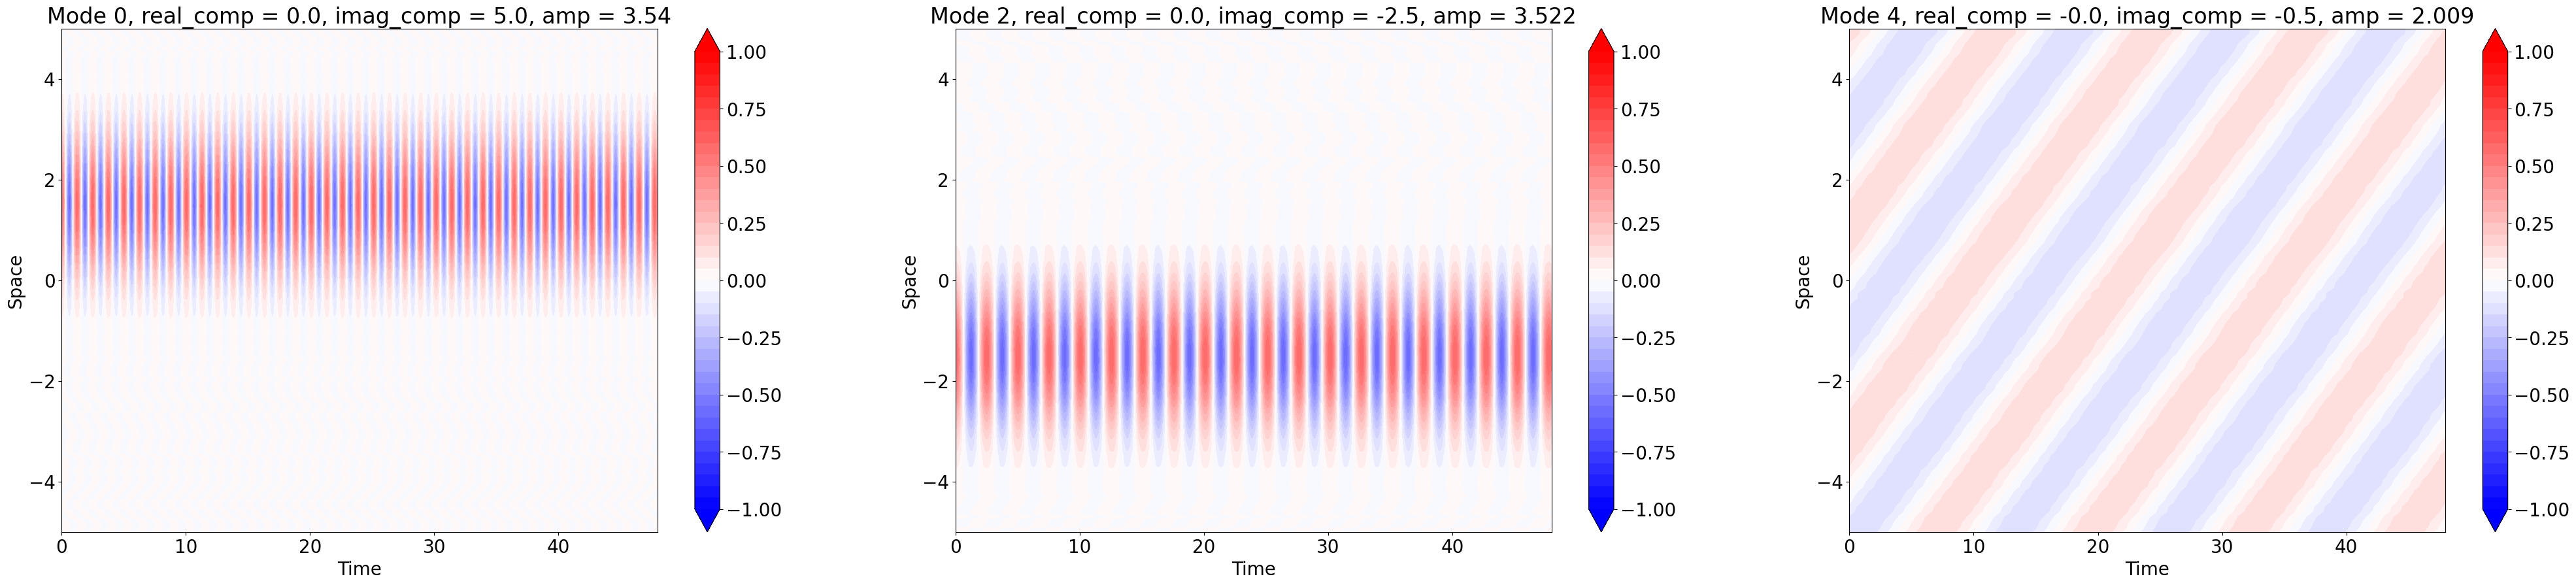

In [12]:
plt.rcParams.update({'font.size': 20}) 

fig = plt.figure(figsize=(50, 10))

which_modes = [0, 2, 4]

vmin = -1; vmax = 1
levels = np.arange(vmin, vmax+0.05, 0.05)

X, T = np.meshgrid(signal_generator.x, t_train)


ax = fig.add_subplot(1, 3, 1)
reconstruction = reconstruct(modes[:, which_modes[0]], eigs[which_modes[0]], amps[which_modes[0]])
contour = ax.contourf(T, X, reconstruction.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Mode {which_modes[0]}, real_comp = {np.round(eigs[which_modes[0]].real, 3)}, imag_comp = {np.round(eigs[which_modes[0]].imag, 3)}, amp = {np.round(amps[which_modes[0]], 3)}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
reconstruction = reconstruct(modes[:, which_modes[1]], eigs[which_modes[1]], amps[which_modes[1]])
contour = ax.contourf(T, X, reconstruction.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Mode {which_modes[1]}, real_comp = {np.round(eigs[which_modes[1]].real, 3)}, imag_comp = {np.round(eigs[which_modes[1]].imag, 3)}, amp = {np.round(amps[which_modes[1]], 3)}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 3)
reconstruction = reconstruct(modes[:, which_modes[2]], eigs[which_modes[2]], amps[which_modes[2]])
contour = ax.contourf(T, X, reconstruction.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Mode {which_modes[2]}, real_comp = {np.round(eigs[which_modes[2]].real, 3)}, imag_comp = {np.round(eigs[which_modes[2]].imag, 3)}, amp = {np.round(amps[which_modes[2]], 3)}')
plt.colorbar(contour, ax=ax, orientation="vertical")


Produce a forecast and compare to the data we held out.

In [13]:
forecast = delay_optdmd.forecast(t_test)
forecast = forecast[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast = forecast.T
forecast = forecast.real

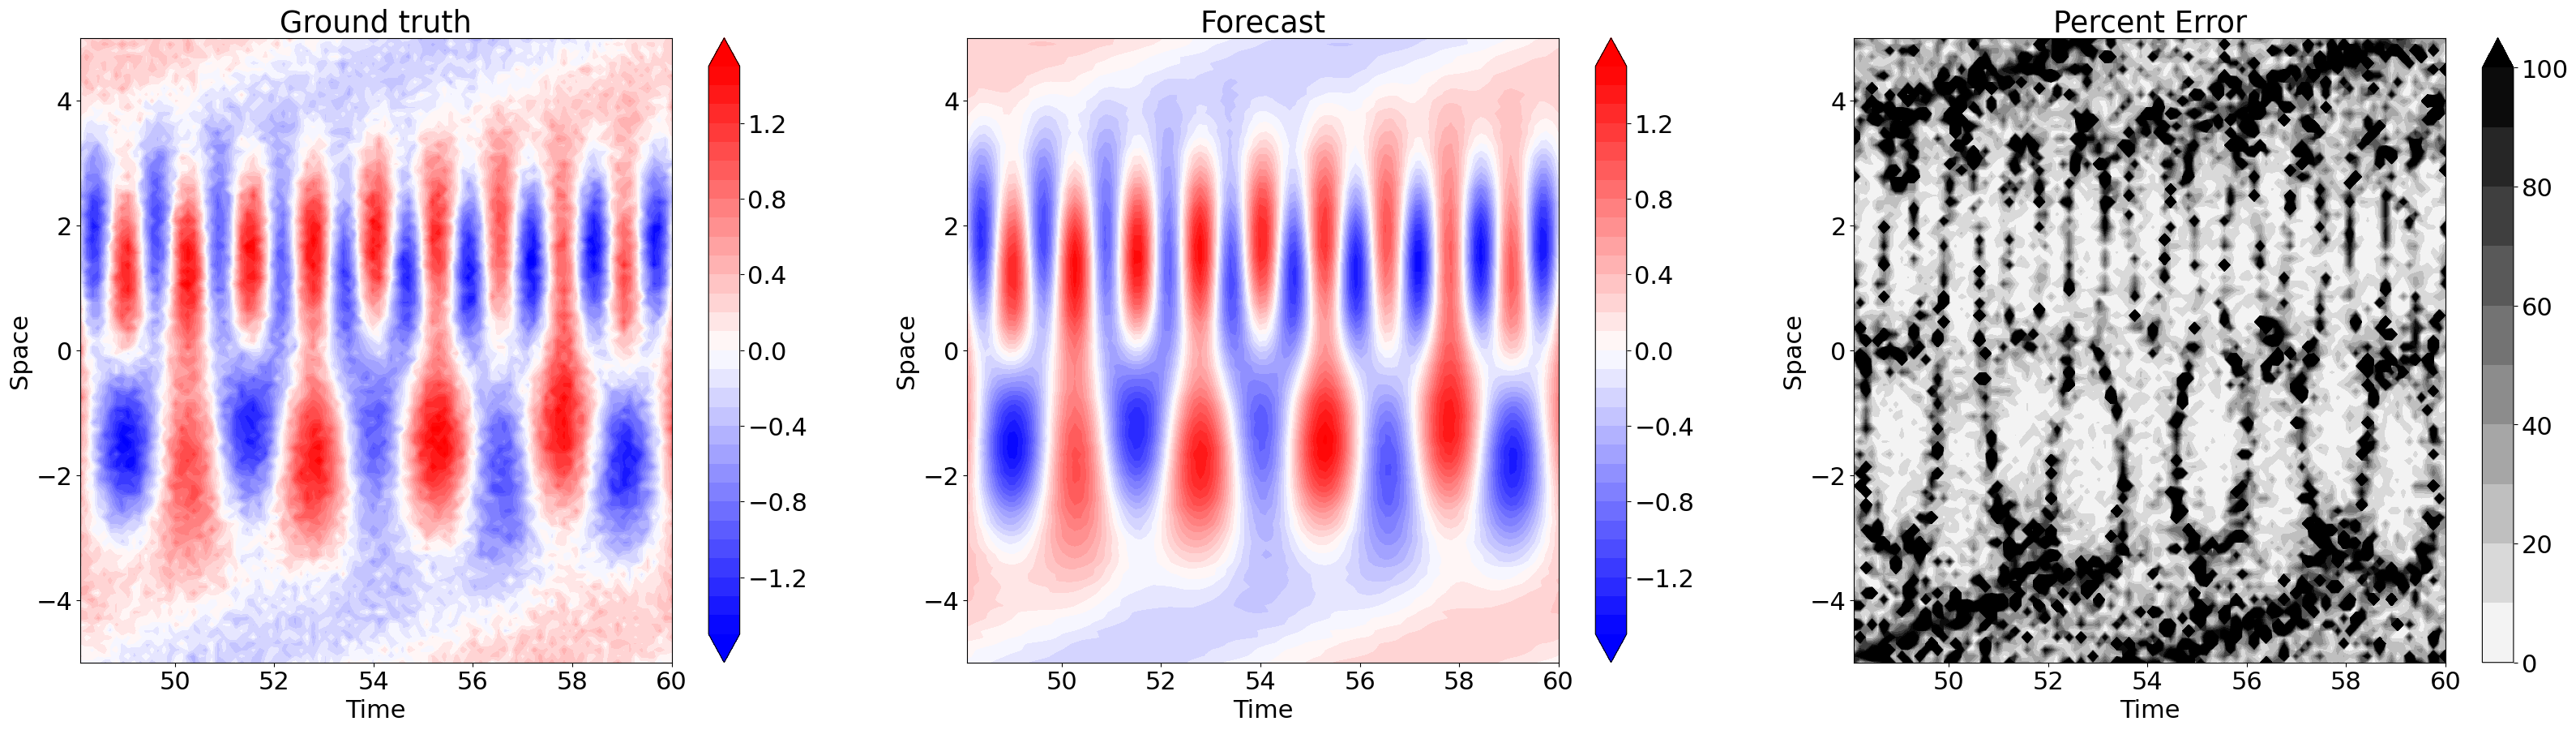

In [14]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(f_test - forecast) / np.abs(f_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

## Conclusion

Algorithm 3 of Askham and Kutz (2018) is able to accurately capture the three sinusoids that compose the signal in terms of spatial and temporal dynamics. The mode frequencies are very close to the true frequencies of the sinusoids, and so are the mode amplitudes. The contours of the reconstructed data from each mode are plotted. The forecast is also compared to the data we held out.
